In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [20]:
loan_data = pd.read_csv('../input/loan-data-2015/loan_data_2015.csv')

In [21]:
pd.options.display.max_columns = None
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,60516983,64537751,20000,20000,20000,36 months,12.29,667.06,C,C1,Accounting Clerk,1 year,OWN,65000.0,Source Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,542xx,WI,20.72,0,Sep-00,1,NaN,NaN,25,0,31578,77.0,42,w,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,NaN,0.00,NaN,Jan-16,0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,0,52303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41000,NaN,NaN,NaN
1,60187139,64163931,11000,11000,11000,36 months,12.69,369.00,C,C2,Accounts Payable Lead,7 years,MORTGAGE,40000.0,Source Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,235xx,VA,24.57,0,Sep-02,0,36.0,80.0,13,1,5084,38.8,41,w,0.0,0.0,10043.49,10043.49,9942.67,100.81,0.0,0.0,0.0,Oct-15,10059.00,NaN,Jan-16,0,79.0,1,INDIVIDUAL,NaN,NaN,NaN,0,332,175731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13100,NaN,NaN,NaN
2,60356453,64333218,7000,7000,7000,36 months,9.99,225.84,B,B3,Nurse,6 years,MORTGAGE,32000.0,Source Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,350xx,AL,32.41,0,Feb-06,1,NaN,NaN,18,0,12070,74.0,36,f,0.0,0.0,221.96,221.96,167.56,54.40,0.0,0.0,0.0,Oct-15,225.84,NaN,Jan-16,0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,0,202012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16300,NaN,NaN,NaN
3,59955769,63900496,10000,10000,10000,36 months,10.99,327.34,B,B4,Service Manager,10+ years,MORTGAGE,48000.0,Source Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Credit card refinancing,483xx,MI,30.98,0,Oct-99,2,NaN,NaN,18,0,22950,66.0,41,f,0.0,0.0,315.13,315.13,235.76,79.37,0.0,0.0,0.0,Oct-15,327.34,NaN,Jan-16,0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,0,108235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34750,NaN,NaN,NaN
4,58703693,62544456,9550,9550,9550,36 months,19.99,354.87,E,E4,NaN,NaN,RENT,32376.0,Verified,Sep-15,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,546xx,WI,32.54,0,Nov-99,3,69.0,NaN,9,0,4172,29.6,26,w,0.0,0.0,333.66,333.66,195.78,137.88,0.0,0.0,0.0,Oct-15,354.87,NaN,Jan-16,0,69.0,1,INDIVIDUAL,NaN,NaN,NaN,0,0,45492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14100,NaN,NaN,NaN


In [22]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           421094 non-null  int64  
 1   member_id                    421094 non-null  int64  
 2   loan_amnt                    421094 non-null  int64  
 3   funded_amnt                  421094 non-null  int64  
 4   funded_amnt_inv              421094 non-null  int64  
 5   term                         421094 non-null  object 
 6   int_rate                     421094 non-null  float64
 7   installment                  421094 non-null  float64
 8   grade                        421094 non-null  object 
 9   sub_grade                    421094 non-null  object 
 10  emp_title                    397220 non-null  object 
 11  emp_length                   397277 non-null  object 
 12  home_ownership               421094 non-null  object 
 13 

In [23]:
na_values = loan_data.isnull().mean()
na_values[na_values>0.8]

desc                         0.999893
mths_since_last_record       0.823282
annual_inc_joint             0.998786
dti_joint                    0.998791
verification_status_joint    0.998786
open_acc_6m                  0.949246
open_il_6m                   0.949246
open_il_12m                  0.949246
open_il_24m                  0.949246
mths_since_rcnt_il           0.950581
total_bal_il                 0.949246
il_util                      0.955789
open_rv_12m                  0.949246
open_rv_24m                  0.949246
max_bal_bc                   0.949246
all_util                     0.949246
inq_fi                       0.949246
total_cu_tl                  0.949246
inq_last_12m                 0.949246
dtype: float64

In [24]:
loan_data.dropna(thresh = loan_data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)
loan_data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'title', 'zip_code', 'next_pymnt_d',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

In [25]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    421094 non-null  int64  
 1   funded_amnt                  421094 non-null  int64  
 2   funded_amnt_inv              421094 non-null  int64  
 3   term                         421094 non-null  object 
 4   int_rate                     421094 non-null  float64
 5   installment                  421094 non-null  float64
 6   grade                        421094 non-null  object 
 7   emp_length                   397277 non-null  object 
 8   home_ownership               421094 non-null  object 
 9   annual_inc                   421094 non-null  float64
 10  verification_status          421094 non-null  object 
 11  issue_d                      421094 non-null  object 
 12  loan_status                  421094 non-null  object 
 13 

In [26]:
loan_data['loan_status'].value_counts(normalize = True)

Current               0.896600
Fully Paid            0.054582
Issued                0.020091
Late (31-120 days)    0.011140
In Grace Period       0.007378
Charged Off           0.006585
Late (16-30 days)     0.002705
Default               0.000919
Name: loan_status, dtype: float64

In [27]:
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)
loan_data.drop(columns = ['loan_status'], inplace = True)

In [28]:
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_test = X_train.copy(), X_test.copy()

In [29]:
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

emp_length_converter(X_train, 'emp_length')
X_train['emp_length'].unique()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


array([10.,  2.,  6.,  1.,  3.,  4.,  8.,  9.,  0.,  5.,  7.])

In [30]:
def date_columns(df, column):
    today_date = pd.to_datetime('2020-08-01')
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    df.drop(columns = [column], inplace = True)

date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')

print(X_train['mths_since_earliest_cr_line'].describe())
print(X_train['mths_since_issue_d'].describe())
print(X_train['mths_since_last_pymnt_d'].describe())
print(X_train['mths_since_last_credit_pull_d'].describe())

count    336875.000000
mean        262.388435
std          90.717277
min          93.000000
25%         200.000000
50%         244.000000
75%         310.000000
max         619.000000
Name: mths_since_earliest_cr_line, dtype: float64
count    336875.000000
mean         61.045171
std           3.455841
min          56.000000
25%          58.000000
50%          61.000000
75%          64.000000
max          67.000000
Name: mths_since_issue_d, dtype: float64
count    322988.000000
mean         55.508242
std           1.292614
min          55.000000
25%          55.000000
50%          55.000000
75%          56.000000
max          67.000000
Name: mths_since_last_pymnt_d, dtype: float64
count    336865.000000
mean         55.152497
std           0.897343
min          55.000000
25%          55.000000
50%          55.000000
75%          55.000000
max          68.000000
Name: mths_since_last_credit_pull_d, dtype: float64


In [31]:
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

loan_term_converter(X_train, 'term')

In [32]:
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()


In [33]:
chi2_check = {}
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,grade,0.000000
1,home_ownership,0.000000
2,verification_status,0.000000
3,purpose,0.000000
4,addr_state,0.000000
5,initial_list_status,0.000000
6,application_type,0.028142
7,pymnt_plan,1.000000


Let's keep only the top four categorical features

In [34]:
X_train_num.fillna(X_train_num.mean(), inplace = True)
F_statistic, p_values = f_classif(X_train_num, y_train)
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [25] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,48151.262635,0.000000e+00
1,mths_since_issue_d,5022.870198,0.000000e+00
2,int_rate,4335.700503,0.000000e+00
3,out_prncp,1302.251647,0.000000e+00
4,out_prncp_inv,1302.222886,0.000000e+00
5,inq_last_6mths,525.882831,0.000000e+00
6,mths_since_last_credit_pull_d,464.505497,0.000000e+00
7,total_pymnt,211.946776,0.000000e+00
8,total_pymnt_inv,211.869294,0.000000e+00
9,last_pymnt_amnt,206.562975,0.000000e+00


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


Text(0.5, 1.0, 'Pearson correlation')

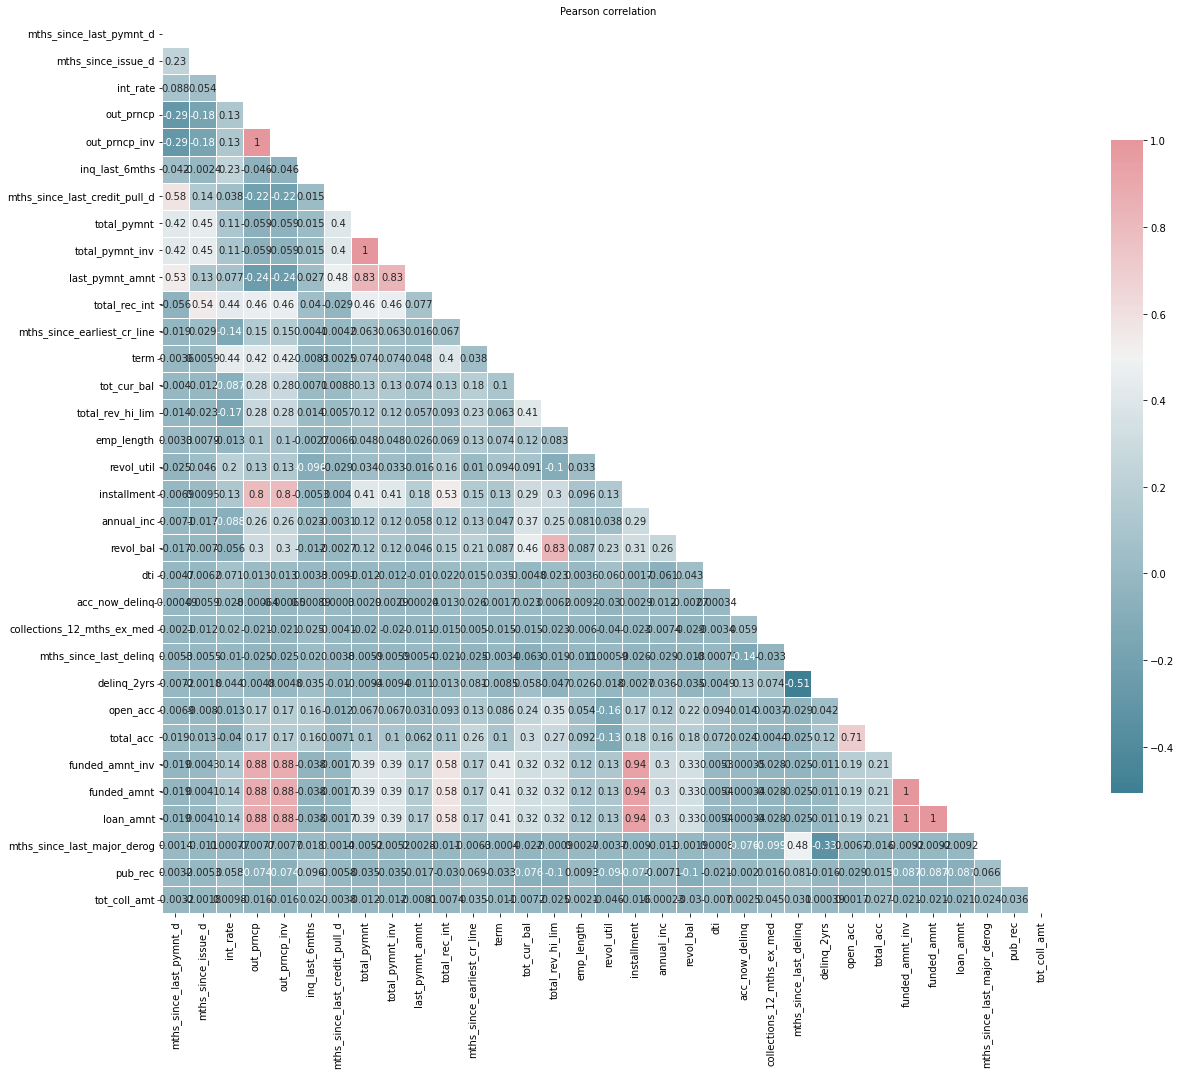

In [35]:
top_num_features = ANOVA_F_table.iloc[:33,0].to_list()
corrmat = X_train_num[top_num_features].corr()
mask = np.triu(np.ones_like(corrmat, dtype=np.bool))
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrmat, cmap= cmap, mask= mask, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .6},annot=True)

plt.title("Pearson correlation", fontsize =10)


In [36]:
drop_columns_list = ANOVA_F_table.iloc[33:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv','funded_amnt','funded_amnt_inv'])

def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

col_to_drop(X_train, drop_columns_list)

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336875 entries, 304531 to 312076
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      336875 non-null  int64  
 1   term                           336875 non-null  int64  
 2   int_rate                       336875 non-null  float64
 3   installment                    336875 non-null  float64
 4   grade                          336875 non-null  object 
 5   emp_length                     336875 non-null  float64
 6   home_ownership                 336875 non-null  object 
 7   annual_inc                     336875 non-null  float64
 8   verification_status            336875 non-null  object 
 9   purpose                        336875 non-null  object 
 10  dti                            336875 non-null  float64
 11  delinq_2yrs                    336875 non-null  int64  
 12  inq_last_6mths           

In [38]:
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])

In [39]:
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(336875, 61)
(336875,)
(84219, 61)
(84219,)


In [90]:
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])
# cross-validation criteria
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.9085
Gini: 0.8171


In [91]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0           20000        20000            20000   36 months     12.29   
1           11000        11000            11000   36 months     12.69   
2            7000         7000             7000   36 months      9.99   
3           10000        10000            10000   36 months     10.99   
4            9550         9550             9550   36 months     19.99   
...           ...          ...              ...         ...       ...   
421089      25000        25000            25000   36 months     20.99   
421090       5875         5875             5875   36 months     15.59   
421091      10000        10000            10000   60 months     23.99   
421092      1960...
421092                          NaN            1       INDIVIDUAL   
421093                         69.0            1       INDIVIDUAL   

        acc_now_delinq  tot_coll_amt  tot_cur_bal  total

In [92]:
X_train_woe_transformed = woe_transform.fit_transform(X_train)
feature_name = X_train_woe_transformed.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,4.207386
1,grade:A,3.608510
2,grade:B,2.722064
3,grade:C,2.232001
4,grade:D,1.772301
...,...,...
78,mths_since_issue_d:89-100,-1.490460
79,mths_since_issue_d:100-122,-2.791894
80,mths_since_last_credit_pull_d:missing,-4.984530
81,mths_since_last_credit_pull_d:<56,-1.013446


Predictions

In [ ]:
y_hat_test = pipeline.predict(X_test)
y_hat_test_proba = pipeline.predict_proba(X_test) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [94]:
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
y_test_proba.shape

(84219, 2)

In [95]:
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.index = X_test.index
y_test_proba

,y_test_class_actual,y_hat_test_proba
85226,1,0.984750
135248,1,0.887360
124342,1,0.993215
318929,1,0.813582
49176,1,0.950860
...,...,...
287341,1,0.858190
401921,1,0.333275
63105,1,0.877336
358896,1,0.289618


Confusion Matrix & AUROC 

In [96]:
#threshold
tr = 0.5
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.01516285, 0.00347902],
       [0.15466819, 0.82668994]])

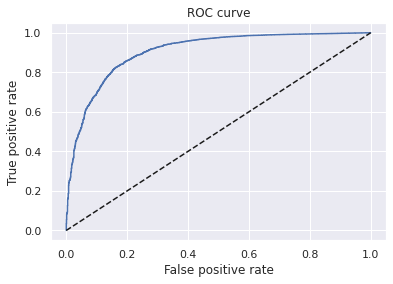

In [97]:
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [98]:
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC


0.9051244527062607

In [99]:
Gini = AUROC * 2 - 1
Gini

0.8102489054125215

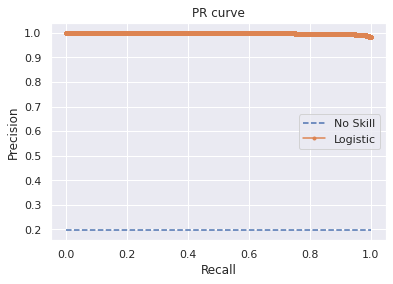

In [100]:
no_skill = len(y_test[y_test == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [101]:
auc_pr = auc(recall, precision)
auc_pr

0.997578707851294

Scorecard Creation

In [102]:
summary_table

,Feature name,Coefficients
0,Intercept,4.207386
1,grade:A,3.608510
2,grade:B,2.722064
3,grade:C,2.232001
4,grade:D,1.772301
...,...,...
78,mths_since_issue_d:89-100,-1.490460
79,mths_since_issue_d:100-122,-2.791894
80,mths_since_last_credit_pull_d:missing,-4.984530
81,mths_since_last_credit_pull_d:<56,-1.013446


In [103]:
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,mths_since_last_credit_pull_d:>75,0
1,mths_since_issue_d:>122,0
2,mths_since_earliest_cr_line:>434,0
3,"total_rev_hi_lim:>79,780",0
4,"total_rec_int:>7,260",0
5,"total_pymnt:>25,000",0
6,"out_prncp:>15,437",0
7,revol_util:>1.0,0
8,inq_last_6mths:>4,0
9,dti:>35.191,0


In [104]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,4.207386
1,1,grade:A,3.608510
2,2,grade:B,2.722064
3,3,grade:C,2.232001
4,4,grade:D,1.772301
...,...,...,...
95,12,term:60,0.000000
96,13,purpose:major_purch__car__home_impr,0.000000
97,14,verification_status:Not Verified,0.000000
98,15,home_ownership:MORTGAGE,0.000000


In [105]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,4.207386,Intercept
1,1,grade:A,3.608510,grade
2,2,grade:B,2.722064,grade
3,3,grade:C,2.232001,grade
4,4,grade:D,1.772301,grade
...,...,...,...,...
95,12,term:60,0.000000,term
96,13,purpose:major_purch__car__home_impr,0.000000,purpose
97,14,verification_status:Not Verified,0.000000,verification_status
98,15,home_ownership:MORTGAGE,0.000000,home_ownership


In [106]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [107]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,4.207386,Intercept,603.962945,604.0
1,1,grade:A,3.608510,grade,52.885208,53.0
2,2,grade:B,2.722064,grade,39.893727,40.0
3,3,grade:C,2.232001,grade,32.711526,33.0
4,4,grade:D,1.772301,grade,25.974297,26.0
...,...,...,...,...,...,...
95,12,term:60,0.000000,term,0.000000,0.0
96,13,purpose:major_purch__car__home_impr,0.000000,purpose,0.000000,0.0
97,14,verification_status:Not Verified,0.000000,verification_status,0.000000,0.0
98,15,home_ownership:MORTGAGE,0.000000,home_ownership,0.000000,0.0


In [108]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

301.0
851.0


In [109]:
pd.options.display.max_rows = 102
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,4.207386,Intercept,603.962945,604.0,0.037055
1,1,grade:A,3.608510,grade,52.885208,53.0,0.114792
2,2,grade:B,2.722064,grade,39.893727,40.0,0.106273
3,3,grade:C,2.232001,grade,32.711526,33.0,0.288474
4,4,grade:D,1.772301,grade,25.974297,26.0,0.025703
5,5,grade:E,1.363654,grade,19.985289,20.0,0.014711
6,6,grade:F,0.710574,grade,10.413951,10.0,-0.413951
7,7,home_ownership:OWN,-0.210022,home_ownership,-3.078023,-3.0,0.078023
8,8,home_ownership:OTHER_NONE_RENT,-0.223855,home_ownership,-3.280744,-3.0,0.280744
9,9,verification_status:Source Verified,-0.423076,verification_status,-6.200466,-6.0,0.200466


In [110]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 653
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,4.207386,Intercept,603.962945,604.0,0.037055,653.0
1,1,grade:A,3.608510,grade,52.885208,53.0,0.114792,53.0
2,2,grade:B,2.722064,grade,39.893727,40.0,0.106273,40.0
3,3,grade:C,2.232001,grade,32.711526,33.0,0.288474,33.0
4,4,grade:D,1.772301,grade,25.974297,26.0,0.025703,26.0
5,5,grade:E,1.363654,grade,19.985289,20.0,0.014711,20.0
6,6,grade:F,0.710574,grade,10.413951,10.0,-0.413951,10.0
7,7,home_ownership:OWN,-0.210022,home_ownership,-3.078023,-3.0,0.078023,-3.0
8,8,home_ownership:OTHER_NONE_RENT,-0.223855,home_ownership,-3.280744,-3.0,0.280744,-3.0
9,9,verification_status:Source Verified,-0.423076,verification_status,-6.200466,-6.0,0.200466,-6.0


In [111]:
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

350.0
900.0


In [112]:
X_test_woe_transformed = woe_transform.fit_transform(X_test)
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:OTHER_NONE_RENT,verification_status:Source Verified,verification_status:Verified,purpose:debt_consolidation,purpose:credit_card,purpose:educ__ren_en__sm_b__mov,purpose:vacation__house__wedding__med__oth,term:36,int_rate:<7.071,int_rate:7.071-10.374,int_rate:10.374-13.676,int_rate:13.676-15.74,int_rate:15.74-20.281,annual_inc:missing,"annual_inc:<28,555","annual_inc:28,555-37,440","annual_inc:37,440-61,137","annual_inc:61,137-81,872","annual_inc:81,872-102,606","annual_inc:102,606-120,379","annual_inc:120,379-150,000",dti:<=1.6,dti:1.6-5.599,dti:5.599-10.397,dti:10.397-15.196,dti:15.196-19.195,dti:19.195-24.794,dti:24.794-35.191,inq_last_6mths:missing,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-4,revol_util:missing,revol_util:<0.1,revol_util:0.1-0.2,revol_util:0.2-0.3,revol_util:0.3-0.4,revol_util:0.4-0.5,revol_util:0.5-0.6,revol_util:0.6-0.7,revol_util:0.7-0.8,revol_util:0.8-0.9,revol_util:0.9-1.0,"out_prncp:<1,286","out_prncp:1,286-6,432","out_prncp:6,432-9,005","out_prncp:9,005-10,291","out_prncp:10,291-15,437","total_pymnt:<10,000","total_pymnt:10,000-15,000","total_pymnt:15,000-20,000","total_rec_int:<1,089","total_rec_int:1,089-2,541","total_rec_int:2,541-4,719","total_rec_int:4,719-7,260",total_rev_hi_lim:missing,"total_rev_hi_lim:<6,381","total_rev_hi_lim:6,381-19,144","total_rev_hi_lim:19,144-25,525","total_rev_hi_lim:25,525-35,097","total_rev_hi_lim:35,097-54,241","total_rev_hi_lim:54,241-79,780",mths_since_earliest_cr_line:missing,mths_since_earliest_cr_line:<125,mths_since_earliest_cr_line:125-167,mths_since_earliest_cr_line:167-249,mths_since_earliest_cr_line:249-331,mths_since_earliest_cr_line:331-434,mths_since_issue_d:<79,mths_since_issue_d:79-89,mths_since_issue_d:89-100,mths_since_issue_d:100-122,mths_since_last_credit_pull_d:missing,mths_since_last_credit_pull_d:<56,mths_since_last_credit_pull_d:56-61
85226,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
135248,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
124342,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
318929,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
49176,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [113]:
scorecard_scores = df_scorecard['Score - Final']
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(84219, 83)
(100,)


In [114]:
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
scorecard_scores = scorecard_scores.values.reshape(100, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(84219, 100)
(100, 1)


In [115]:
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores

,0
85226,652.0
135248,620.0
124342,663.0
318929,612.0
49176,634.0
...,...
287341,618.0
401921,581.0
63105,620.0
358896,577.0


In [116]:
y_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84219 entries, 85226 to 118334
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       84219 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


In [117]:
y_scores = y_scores.rename(columns = {0: 'Score'}, inplace = False)

In [118]:
y_scores.sort_values(by='Score')

,Score
2255,458.0
351265,471.0
1540,472.0
421062,472.0
2597,473.0
...,...
44592,756.0
57569,756.0
74201,759.0
7233,759.0


Loan approval cut-offs

In [119]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))


Best Threshold: 0.244726


In [120]:
tr = best_thresh
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.01129199, 0.00734989],
       [0.04209264, 0.93926549]])

In [121]:
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs

,thresholds,Score
0,0.000292,423.0
1,0.000294,423.0
2,0.000309,424.0
3,0.000374,427.0
4,0.000406,428.0
...,...,...
81536,0.999985,705.0
81537,0.999988,708.0
81538,0.999988,709.0
81539,0.999989,709.0


In [122]:
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [123]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.000292,423.0,84217,2,0.999976,0.000024
1,0.000294,423.0,84216,3,0.999964,0.000036
2,0.000309,424.0,84215,4,0.999953,0.000047
3,0.000374,427.0,84214,5,0.999941,0.000059
4,0.000406,428.0,84213,6,0.999929,0.000071
...,...,...,...,...,...,...
81536,0.999985,705.0,5,84214,0.000059,0.999941
81537,0.999988,708.0,4,84215,0.000047,0.999953
81538,0.999988,709.0,3,84216,0.000036,0.999964
81539,0.999989,709.0,2,84217,0.000024,0.999976


In [124]:
df_cutoffs[df_cutoffs['thresholds'].between(0.24448, 0.24489)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
4457,0.244515,526.0,79728,4491,0.946675,0.053325
4458,0.244518,526.0,79727,4492,0.946663,0.053337
4459,0.244526,526.0,79726,4493,0.946651,0.053349
4460,0.244575,526.0,79725,4494,0.946639,0.053361
4461,0.244726,526.0,79724,4495,0.946627,0.053373
4462,0.244819,526.0,79723,4496,0.946615,0.053385
4463,0.244871,526.0,79722,4497,0.946603,0.053397


Thus, threshold yeilds our Credit Score as 526 which can be used for loan cutoffs.